In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
import numpy as np
import os

# Path to the directory containing your images categorized by temperature or velocity
train_dir = '/content/Test'
test_dir = '/content/Train'

# Create ImageDataGenerator instances for train and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories and resize them to (32, 32)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')  # Change class_mode to 'categorical'

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(32, 32),
        batch_size=1,
        class_mode='categorical')  # Change class_mode to 'categorical'

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Transfer learning using VGG19 as the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG19 base
model_transfer = models.Sequential()

# Add the VGG19 base model (excluding the top layers) to the new model
model_transfer.add(base_model)
model_transfer.add(layers.GlobalAveragePooling2D())
model_transfer.add(layers.Dense(128, activation='relu'))
model_transfer.add(layers.Dense(64, activation='relu'))
model_transfer.add(layers.Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the transfer learning model
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary of the transfer learning model architecture
model_transfer.summary()

# Change the batch size
batch_size = 8  # Adjust this according to your dataset size
# Calculate steps_per_epoch
steps_per_epoch = max(1, train_generator.samples // batch_size)

# Calculate validation_steps
validation_steps = max(1, test_generator.samples // batch_size)

# Train the transfer learning model
history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_steps
)


# Evaluate the model on the test set using appropriate metrics
test_loss_transfer, test_acc_transfer = model_transfer.evaluate(test_generator)
print(f'Test accuracy: {test_acc_transfer}')

# Predict on a single image
# Assuming you have a single image file named 'test_image.jpg'
from keras.preprocessing import image

img_path = '/content/Train/Temperature/download (12).png'  # Replace 'path_to_your_test_image.jpg' with your actual image path
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
img_array /= 255.  # Normalize the image

# Make predictions
predictions = model_transfer.predict(img_array)

# Convert predictions to class labels
predicted_class_index = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())

predicted_class = class_labels[predicted_class_index]
print("Predicted class:", predicted_class)

Found 1 images belonging to 2 classes.
Found 1 images belonging to 2 classes.
80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                             

In [ ]:
import numpy as np

# Prompt the user to enter the file number
file_number = input("Enter the file number: ")

# Construct the file name using the provided file number
file_name = f"both_side_1KWcase--{file_number}.38"
file_path = f"/content/Data/{file_name}"

# Specify the column name you want to extract
target_column_name = input('Enter the column name: ')  # Replace 'Column_name' with the actual column name you want

# Read the first row of the ASCII file to get column names
with open(file_path, 'r') as file:
    first_row = file.readline().strip().split()

# Find the index of the target column name
try:
    column_index = first_row.index(target_column_name)
except ValueError:
    print(f"Column '{target_column_name}' not found in the file.")
    exit()

# Read data from the ASCII file, skipping the first row
data = np.loadtxt(file_path, skiprows=1)

# Extract the specified column
column_data = data[:, column_index]

# Print the extracted column data
print("Data from column", target_column_name, ":", column_data)

Enter the file number: 11
Enter the column name: total-temperature
Data from column total-temperature : [301.4282532 301.2369385 300.8686829 ... 301.2244568 301.5619507
 301.7379456]


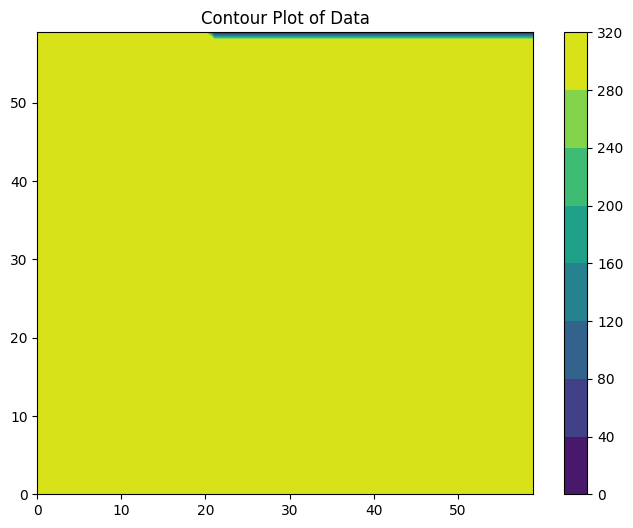

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'column_data' contains the output data
# Reshape the 1D data into a 2D grid
data_length = len(column_data)
num_cols = int(np.sqrt(data_length))  # Determine the number of columns

# Adjust the number of columns if it exceeds the length of the data
if num_cols * num_cols < data_length:
    num_cols += 1

# Calculate the number of rows based on the number of columns
num_rows = int(np.ceil(data_length / num_cols))

# Determine the number of elements in the reshaped array
num_elements = num_rows * num_cols

# Pad the original data with zeros if necessary to ensure the reshaped array has the correct size
column_data_padded = np.pad(column_data, (0, num_elements - data_length), mode='constant', constant_values=0)

# Reshape the padded data into a 2D grid
data_grid = np.reshape(column_data_padded, (num_rows, num_cols))

# Plot the contour
plt.figure(figsize=(8, 6))
plt.contourf(data_grid)
plt.colorbar()  # Add a colorbar for reference
plt.title('Contour Plot of Data')
plt.show()